# An explanation of XGA's hierarchical clustering peak finder

This section aims to explain how the XGA hierarchical clustering peak finder works, rather than how to actually use it. By the end of this you will hopefully have an understanding of the various steps it goes through to measure a peak for an extended source.

In [1]:
from xga.sources import GalaxyCluster

from astropy.units import Quantity, pix
from matplotlib import pyplot as plt
import numpy as np
from astropy.visualization import LogStretch, MinMaxInterval, ImageNormalize, LinearStretch

## Point source disclaimer

This method hasn't been properly tested on point sources, but you should not expect it to work well/at all. The basic premise of this peak finder is that you're looking for the peak of the largest collection of bright pixels, which if you're investigating a cluster is most likely to be the intra-cluster medium emission. 

For point sources however a poorly removed extended source, or just a cluster of vaguely bright pixels could throw off this method. As such the `PointSource` class peak finding is done with the simple method of just looking for the brightest pixel, using the `simple_peak` [method]((../../xga.products.html#xga.products.phot.RateMap.simple_peak)).

## Why find X-ray peaks?

For galaxy cluster analysis it can be difficult to define the 'centre' of a given cluster, but it is crucial that we measure some kind of value for the centre, especially when we wish to produce radial profiles of cluster properties. Different methods are used by different analysis teams, which vary depending on the wavelength of the observation; in optical observations, for instance, the [brightest cluster galaxy (BCG)](https://www.sdss.org/dr15/manga/manga-target-selection/ancillary-targets/brightest-cluster-galaxies/) is often used as a proxy for the centre. 

X-ray astronomers have a distinct advantage here, as the photons we observe trace the actual intra-cluster medium, and so we are in effect tracing the potential well of the halo. As such, the X-ray peak of the cluster is considered a good proxy for the centre (see [Yan et al. (2020)](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1093%2Fmnras%2Fstaa295&v=a899512c) for a comparison of various measures of the centre of cluster using hydrodynamical simulations), and has been used to 'correct' miscentering biases encountered when stacking weak lensing profiles in the DES Y1 cluster cosmology analysis ([Zhang et al. (2019)](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1093%2Fmnras%2Fstz1361&v=4dfe0ea6)).

Once we know the location of the centre of the cluster, we can create analysis regions around it.

## Motivation for a new peak finding method

To correct for the spatial variation of exposure times across the XMM field of view (caused primarily by vignetting), peak finding methods should be performed on a 'ratemap', created by dividing an image by an exposure map. Unfortunately, the calculation of exposure maps seems to become difficult near the edges of CCDs, and can the exposure values can be artificially reduced - this in turn can create artificially bright pixels in the ratemap.

If one of those boosted pixel values happens to be in the region we're searching for a cluster centre, then it is possible that it will be selected over the true centre. Not only that, but if point sources are not properly removed it is possible that the brightest pixel in a given region could be in the remnants of the point source emission.

It is possible to apply a smoothing kernel to try and alleviate some of these problems, but I wanted to try another approach that didn't decrease the spatial resolution, and doesn't need to be checked by eye after the fact.

## Declaring a `GalaxyCluster` instance

The procedure explained in this section is automatically performed (if the user doesn't change the `use_peak` keyword argument to False on initilisation of the source) on the combined `RateMap` data when an `ExtendedSource` or `GalaxyCluster` object is declared. By default, 0.5-2.0keV ratemaps are used, but the user can override this when initialising the source object. This method is also used to find peaks for the individual ratemaps as well, but the combined peak is the main result used by XGA.

Unlike the ratemaps used in this demonstration, the peak finding algorithm built into the `ExtendedSource` and `GalaxyCluster` classes places masks its ratemaps with a search aperture, as well as removing point sources. We have written the demonstration without the use of source masks to demonstrate an absolute worst case scenario.

We choose to use an Abell cluster that has appeared in several of the XGA tutorials, largely because there are two nearby bright point sources that will help illustrate how the peak finder behaves. **Please note that the overdensity radius and redshift used to declare the object are approximate, and shouldn't be used for a real scientific analysis**.

In [2]:
# Abell 907, my favourite Galaxy Cluster!
source = GalaxyCluster(149.5904478, -11.0628750, redshift=0.16, name="A907", r500=Quantity(1200, 'kpc'))

## Accessing the automatically measured peak of a `GalaxyCluster`

Before we get stuck in to the details of the peak finder, you can use the `peak` property to access the coordinates that have been measured as the X-ray peak. If, however, `use_peak` was set to False, these coordinates will actually just be the coordinates passed in on the initialisation of the source:

In [3]:
print(source.peak)

[149.59251341 -11.06395832] deg


If you need a reminder of XGA's photometric products (`RateMap` for instance), I would recommend the [photometry with XGA tutorial](../tutorials/photometry.html).

## The simplest possible peak finder

Firstly we will demonstrate the simplest possible peak finding method, simply selecting the brighest pixel in the ratemap, though first we shall have to retrieve a ratemap from the source storage storage structure, then directly access its data array. We've chosen the PN ratemap from an individual observation, simply to make the visualisation a little simpler:

In [4]:
pn_rt = source.get_ratemaps('0201903501', 'pn', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

We implement an efficient method using numpy to find the coordinates of the maximum value point in an array, then we store the output in an astropy quantity (as well as then converting those pixel coordinates to degrees):

In [5]:
peak = np.unravel_index(np.argmax(pn_rt.data), pn_rt.shape)

# peak[1] goes into the Quantity first because numpy uses row, column ordering, whereas people expect
#  pixel coordinates in column, row ordering.
pn_simple_pix_peak = Quantity([peak[1], peak[0]], pix)
pn_simple_deg_peak = pn_rt.coord_conv(pn_simple_pix_peak, 'deg')

To make our point about the problems that these edge pixels can cause, we use the `view()` method to display the coordinate which has been selected by this simplest peak finding method. A mask (which is the size of the usual search aperture when a source is doing this peak finding iteratively) is applied, and we use the `zoom_in` option so that you can see the bright pixel. 

We also have to set the `mask_edges` argument to False, otherwise an edge mask would have automatically been applied, and you would not be able to see the brightest pixel. 

We change the central coordinate of the mask so that it is centered on the simple peak we have just measured:

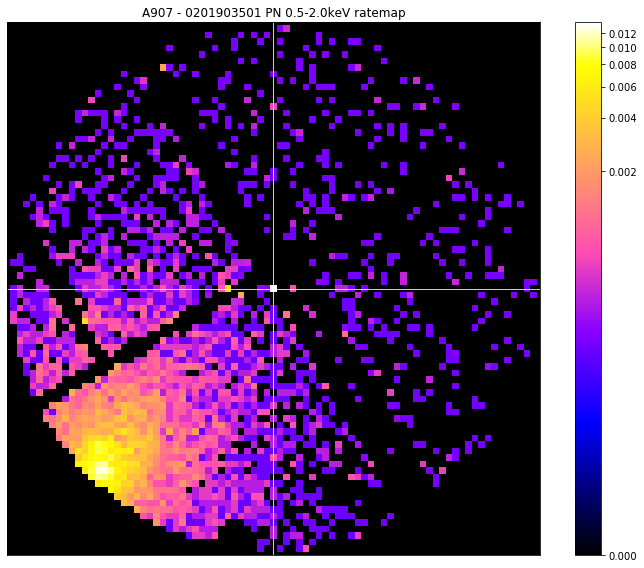

In [6]:
vis_mask = source.get_mask('search', obs_id=pn_rt.obs_id, central_coord=pn_simple_deg_peak)[0]
pn_rt.view(pn_simple_pix_peak, vis_mask, mask_edges=False, zoom_in=True)

You can quite clearly see that the pixel that has been selected is a) on a chip edge, and b) much brighter than anything else in the ratemap (look at the colourbar on the side of the visualisation). Ideally this would have selected the cluster that we can see nearby, but evidently we must deal with these spuriously bright pixels that can appear on chip edges. 

## A solution to the edge problem

We're going to exclude all pixels that sit on the edge of a chip from being peak candidates. As such we need a way to choose which pixels are on an edge and which aren't. We repurposed a method of mapping XMM detectors from another recent piece of work, and used an edge finding algorithm on an exposure map where every value that wasn't 0 was set to 1.

The way this works is that the modified exposure map array is differentiated in the X and Y directions, then the two resultant arrays are added together. As such an edgemap pixel $e_{i,j}$ is

$$e_{i,j} = (p_{i,j} - p_{i+1,j}) + (p_{i,j} - p_{i,j+1})$$

where $p_{i, j}$ is the pixel value of the modified exposure map at coordinates $i, j$.


This makes it easy to know when you're going from 'not on a chip' to 'on a chip' and vice versa; $e_{i,j}$ is -1 when moving from 'not on a chip' to 'on a chip', and 1 when moving from 'on a chip' to 'not on a chip'. The modified exposure map is differentiated in both X and Y directions to make sure we capture all the edges, but some will be detected in both directions, so when the arrays are added together there could be edge map pixels with a value of 2, which generally means they are a corner of a chip.

As we wish to know where the edges are, any values of -1 are shifted over by 1, then set to 1, in the direction of the differentiation they belong to. The array is then inverted, so everywhere **but** the edges is 1.

This technique is implemented in the `RateMap` class, and is run automatically on initialisation. You can manually access the edge mask through the `edge_mask` property, and can see the difference that it makes by changing the `mask_edges` argument of the view method.

Here we show you the ratemap before and after edge masking, as well as the edgemap itself, to demonstrate that we are obviously actually mapping the EPIC pn camera:

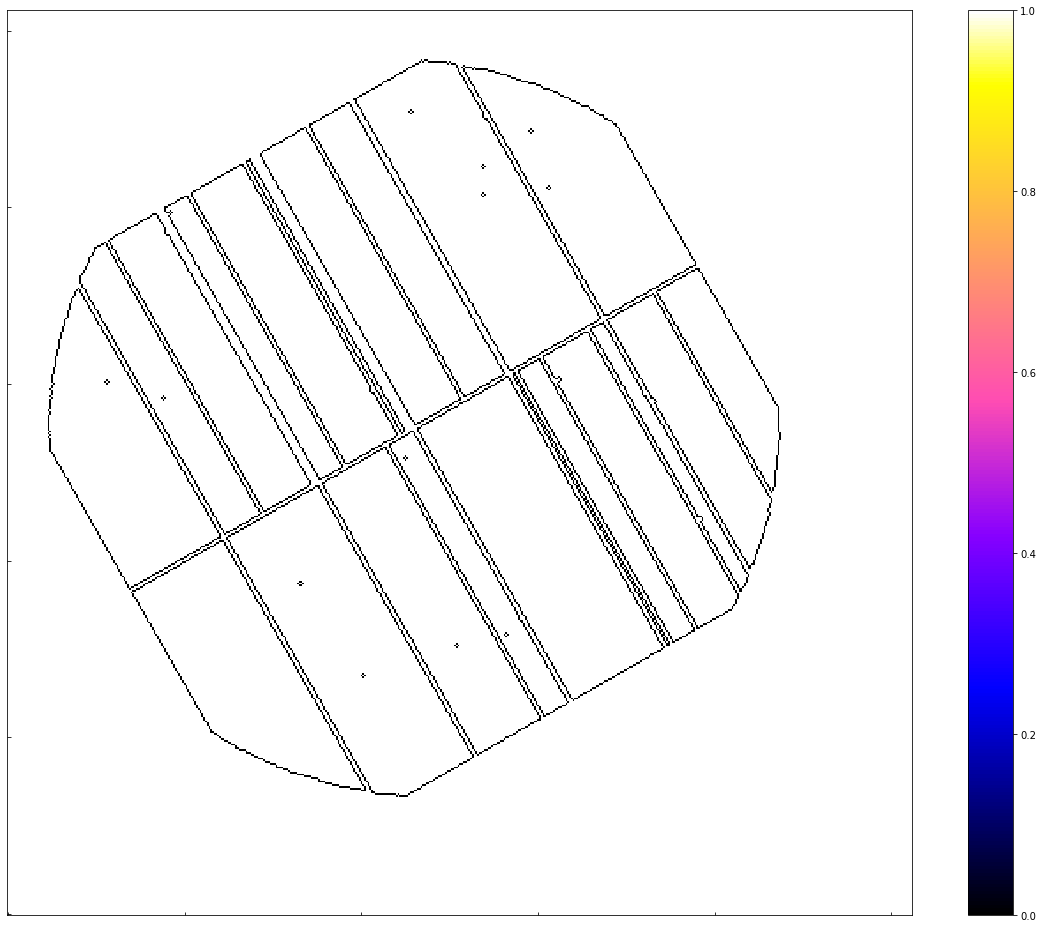

In [7]:
fig = plt.figure(figsize=(16, 13))

ax = plt.gca()

ax.tick_params(axis='both', direction='in', which='both', top=False, right=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

norm = ImageNormalize(data=pn_rt.edge_mask, interval=MinMaxInterval(), stretch=LinearStretch())
ax.imshow(pn_rt.edge_mask, norm=norm, origin="lower", cmap="gnuplot2")

plt.colorbar(ax.images[0])
plt.tight_layout()
plt.show()

The before view:

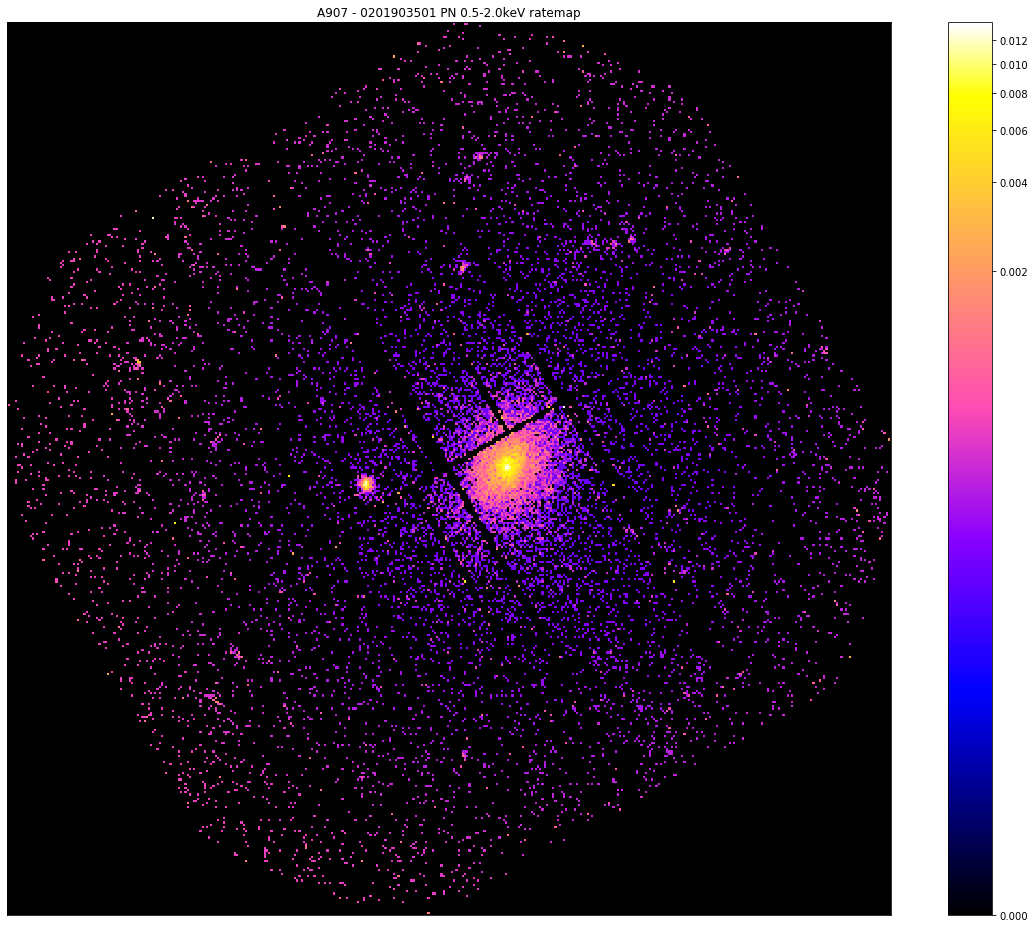

In [8]:
pn_rt.view(zoom_in=True, mask_edges=False, figsize=(16, 13))

The after view: 

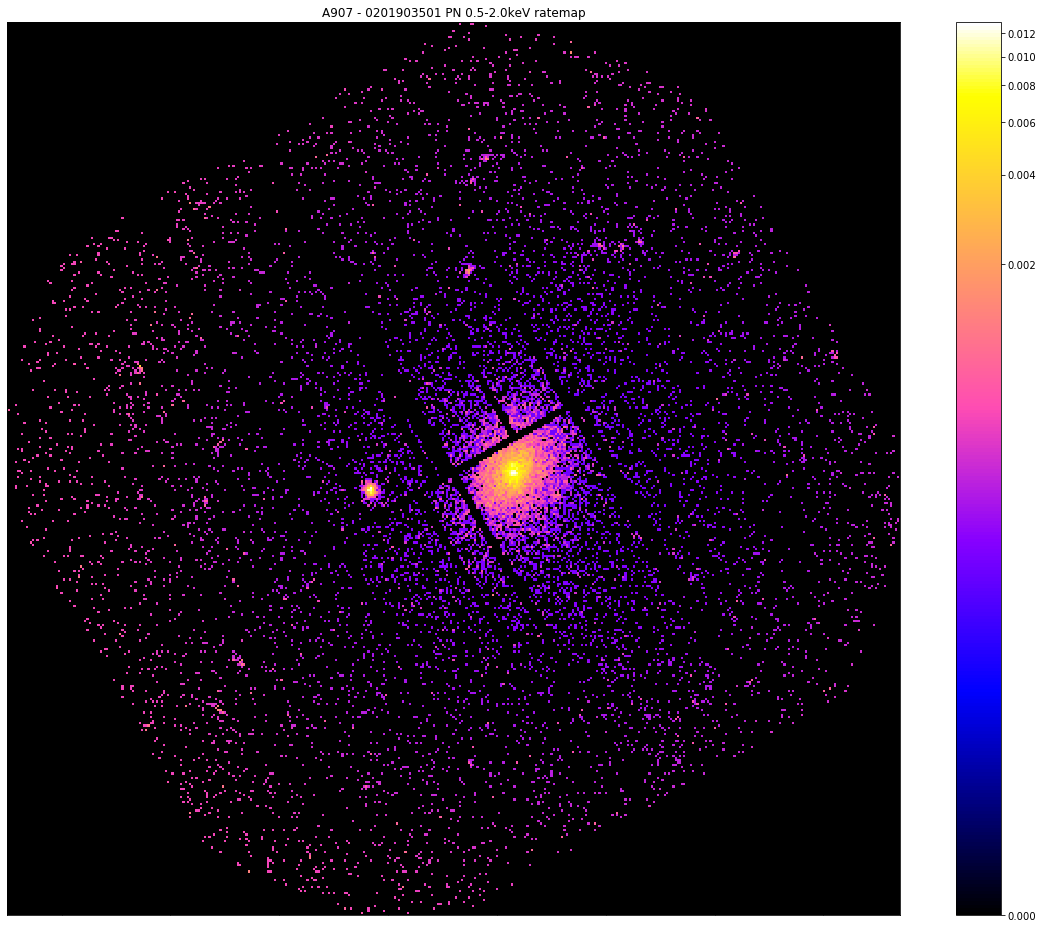

In [9]:
pn_rt.view(zoom_in=True, mask_edges=True, figsize=(16, 13))

Please note that the simple peak finder technique (of looking for the brightest pixel) is implemented as the `simple_peak` [method]((../../xga.products.html#xga.products.phot.RateMap.simple_peak)) of the `RateMap` class, but we apply the edge mask which we just discussed **before** searching for the brightest pixel.

## New Peak Finding Method

To (hopefully) account for any point source remnants in the RateMap, we introduce a new method that uses a hierarchical clustering algorithm to choose the pixels most likely to belong to the cluster we're searching for.

You must bear in mind that by this point in the peak finding function of the `GalaxyCluster` class (for instance) the data is masked to remove point sources, and a search aperture mask is placed around the original coordinates supplied by the user. We choose not to mask the data as it makes it easier to show you what the new method does, and also demonstrates how well it performs even under the worst conditions.

### Demonstrating the downside of the simple peak method

We shall just another ratemap that helps us make our point here:

In [10]:
pn_rt = source.get_ratemaps('0201901401', 'pn', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))

So now that we have developed this edge mask we can apply it and once again search for the brightest pixel, though this time we shall use the built in `simple_peak()` method. When this is called for an actual analysis it expects a mask to be passed to the `mask` argument, to remove sources that shouldn't be considered for the peak position. As we have already stated, we are deliberately not masking this image, so we need to create a flat mask of ones to pass to the peak finder:

In [11]:
# The peak finding methods of a RateMap require a numpy mask, but for the demonstration I don't want to 
#  mask the data, so I construct a numpy array of ones to act as a flat mask
flat_mask = np.ones(pn_rt.shape)
simple_peak, near_edge = pn_rt.simple_peak(flat_mask, 'deg')

We call the view option, having created a custom mask centered on the simple peak we just found and set the `zoom_in` argument to True:

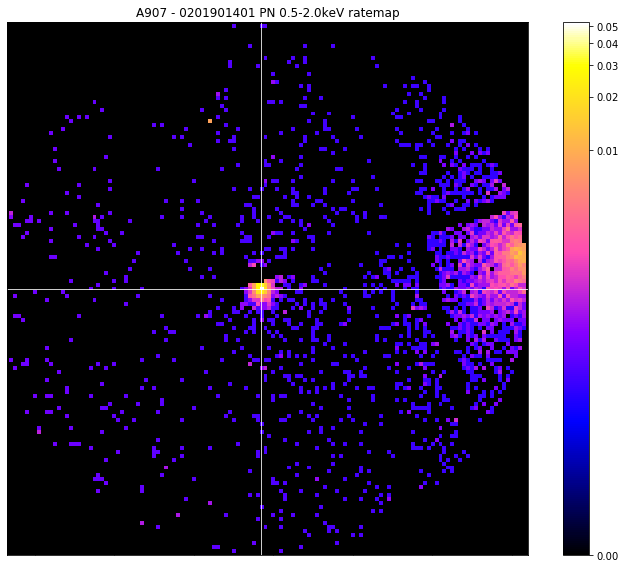

In [12]:
# Then we can view the combined data with the crosshair at the 'simple peak'
vis_mask = source.get_custom_mask(Quantity(0.08, 'deg'), remove_interlopers=False, obs_id=pn_rt.obs_id, 
                                  central_coord=simple_peak)
pn_rt.view(simple_peak, vis_mask, zoom_in=True)

We find that we're still not getting a good answer, and have selected a bright point source instead of the cluster that we can clearly see on the right hand side of the image. 

Now, hopefully in any real use case, the source finder you've used would have found, and produced a region for, a powerful point source like the one we have selected - but the same thing can happen with a particularly bright point source remnant.

### What is hierarchical clustering and how does help?

A clever type of unsupervised machine learning algorithm that can be used to cluster data points in some arbitrary feature space until a completion criteria has been met. In this case we are clustering on X and Y spatial coordinates, so intuitively it is quite easy to understand, but the algorithm can cluster any kind of information.

It starts off by assuming that each point is a separate cluster, then repeatedly identifies the clusters that are closest together and combines them. This XGA implementation uses the scipy `fclusterdata` function, with a distance criterion of five pixels by default, though the distance can be changed by setting the `clustering_peak()` [method's]((../../xga.products.html#xga.products.phot.RateMap.clustering_peak) `max_dist` argument.

We take the spatial coordinates of the pixels with the top 5% (by default) of values in the ratemap, then run this hierarchical clustering algorithm on them. Once it's complete we select the largest cluster of points and assume that this is the source that we're looking for. This excludes any small patches of emission that might be left over from point sources, and so you can just select the pixel with the maximum value **in the chosen point cluster**.

Here we show how the method is called manually, and we have enabled the `clean_point_clusters` function so that any point clusters with fewer than four pixels associated with them are removed from the returned, non-source, point cluster list. This is purely for aesthetic reasons when making the visualisation:

In [13]:
clever_pix_peak, near_edge, src, others = pn_rt.clustering_peak(flat_mask, 'deg', clean_point_clusters=True)

Now we make the visualisation using the `view()` method of the `RateMap` class, particulary with the `chosen_points` and `other_points` arguments, which were specifically designed to plot point clusters from this peak finding algorithm. At first we show the ratemap which the peak finder worked upon, then we show it with the point clusters (and the chosen peak coordinate) plotted on top. 

We can see that the clustering peak finder has noticed the bright point source to the left, but has decided that because the galaxy cluster point cluster is larger, it will take the peak from there:

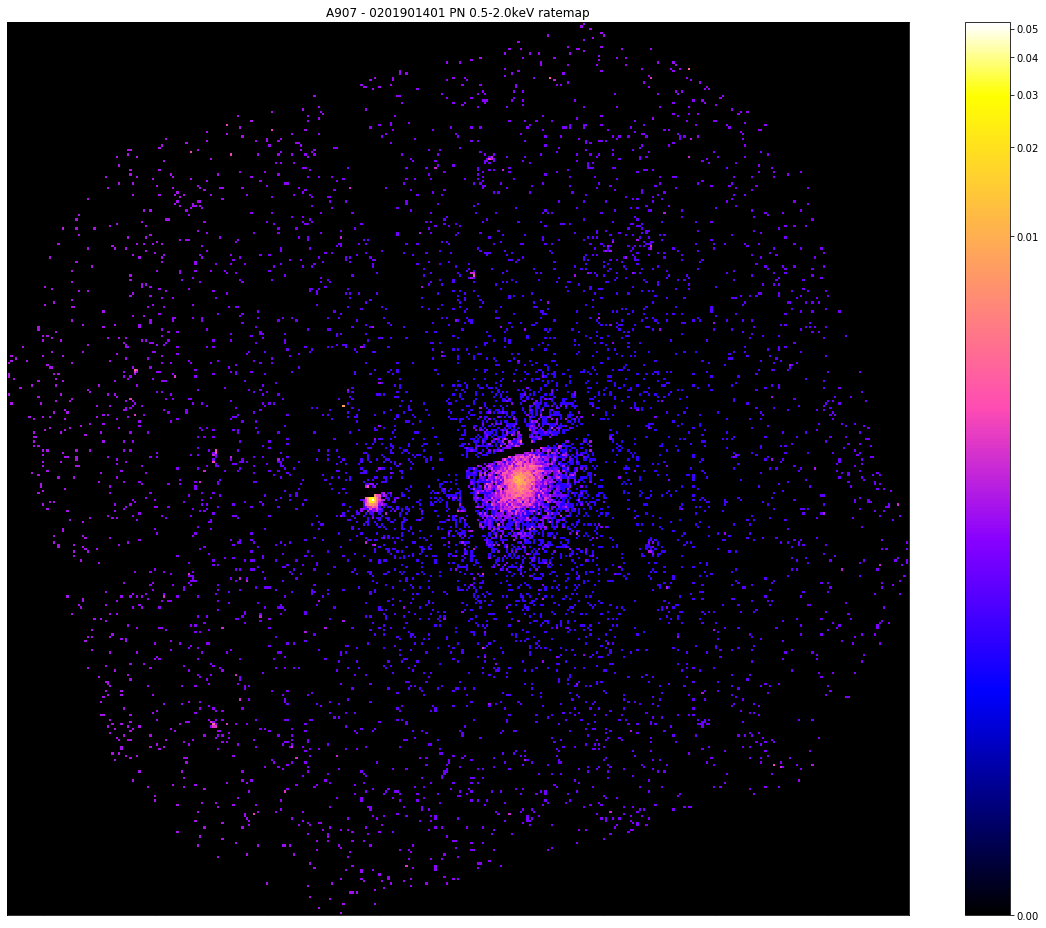

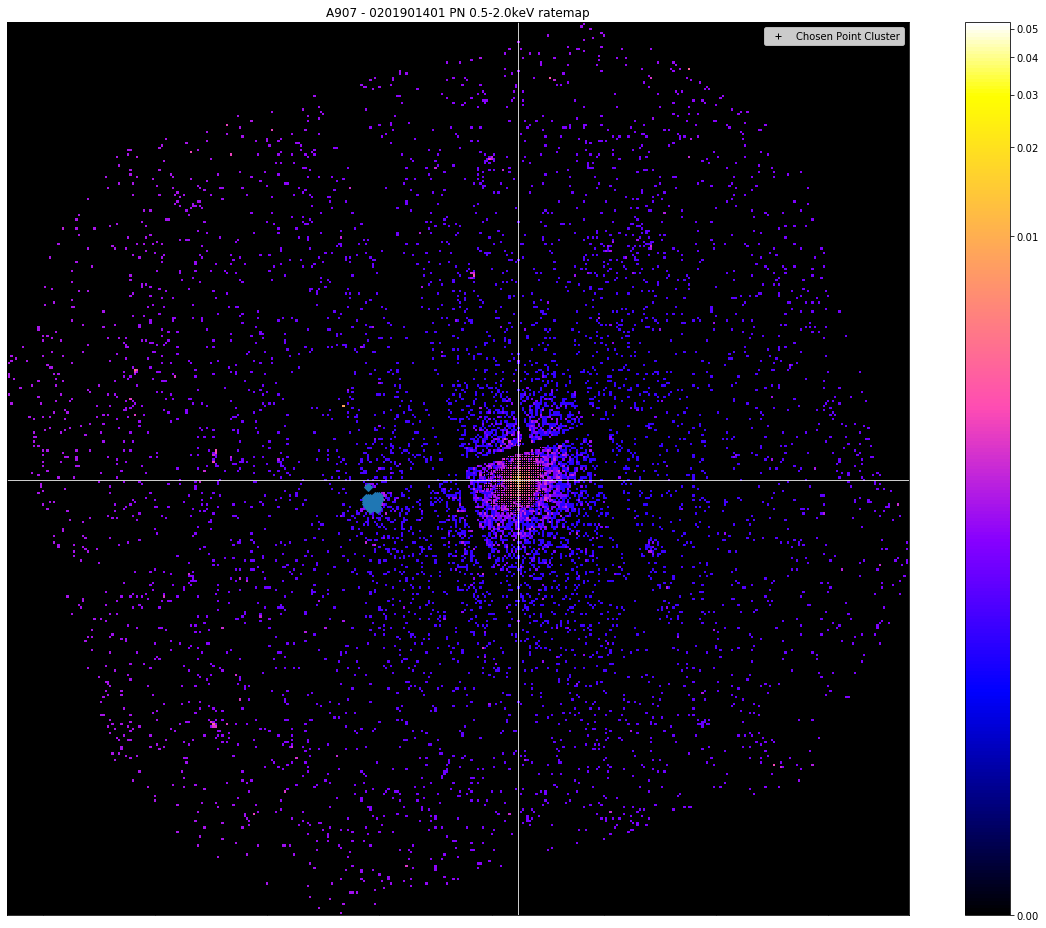

In [14]:
vis_mask = source.get_custom_mask(Quantity(1000, 'kpc'), obs_id=pn_rt.obs_id, central_coord=clever_pix_peak, 
                                  remove_interlopers=False)

pn_rt.view(zoom_in=True, figsize=(16, 13))
pn_rt.view(clever_pix_peak, chosen_points=src, other_points=others, zoom_in=True, figsize=(16, 13))

## How is it implemented in `GalaxyCluster`

The implementation of this process in the ExtendedSource and GalaxyCluster classes is actually iterative. Firstly, an aperture with a radius of 500kpc (or 5 arcminutes) is placed at the user supplied source coordinates, with interloper sources being masked out. The radius is only set to 5 arcminutes if the user has defined an extended source with no redshift information (which is allowed), if the source is a GalaxyCluster object, redshift information is required so it will always use 500kpc.

Then the algorithm follows these steps (for upto 20 iterations before it throws an error):
1. Runs the hierarchical peak finder.
2. Re-centres the search aperture at the new coordinates.
3. Checks to see if the new peak is within 15kpc (or 0.15 arcminutes) of the last central coordinate.
4. If it is, consider the peak converged and exit, if it isn't (or if the algorithm is on the first iteration), go back to 1.

Initially run on the combined ratemap, then on the individual ratemaps of the different observations/instruments. If the combined ratemap peak won't converge, a hard error will be thrown (as this is what XGA analyses uses as the centre), the individual peaks are allowed to not converge.

The user can also choose to use their initial coordinates as the cluster centre, if they don't want to find and use the peak.